# Profil de densité ejecta(e)

Test de 2 modèles de densité d'éjecta présenté dans https://arxiv.org/pdf/1908.05815 (eq. 3)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lal import MSUN_SI, MTSUN_SI, PC_SI, C_SI, G_SI
from pycbc.waveform import get_td_waveform, get_td_waveform_modes
from pycbc.filter import highpass, lowpass
from pycbc.types import TimeSeries
from sympy.physics.wigner import wigner_3j
import gwmemory
from scipy.fft import fft, fftfreq
from matplotlib import cm
from tqdm import tqdm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from gwpy.timeseries import TimeSeries as GWpyTimeSeries
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import PillowWriter

/tmp/ipykernel_4654/4198324317.py:3: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import MSUN_SI, MTSUN_SI, PC_SI, C_SI, G_SI
/usr/local/lib/python3.11/site-packages/pykerr/qnm.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
from lal import C_SI
# Parameters
c = C_SI
f_d_pol = 0.025  # density contrast for polar region

# Angular function (eq 4 - eq 5)
def Theta(theta):
    """Transition function between polar and equatorial regions"""
    return 1.0 / (1.0 + np.exp(-10 * (theta - np.pi/4)))

def eta(theta, f_d_pol=f_d_pol):
    """Angular density profile for dynamical ejecta"""
    return (1 - Theta(theta)) * f_d_pol + Theta(theta)

# Modified density profile function
def rho_profile_model1(r, t, theta, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol=0.025):
    """
    Compute the density profile for a simple ejecta model with dynamical and post-merger components
    Assume that the post-merger ejecta won't reach the highest velocities of the dynamical ejecta
    
    Parameters:
        r: radius (m)
        t: time (s)
        theta: polar angle (radians)
        v_pm_min: minimum velocity for post-merger ejecta (in units of c)
        v_pm_max: maximum velocity for post-merger ejecta (in units of c)
        v_d_min: minimum velocity for dynamical ejecta (in units of c)
        v_max: maximum velocity for dynamical ejecta (in units of c) = 0.9 c
    Returns:
        rho_dyn: density of dynamical ejecta
        rho_pm: density of post-merger ejecta
        rho_tot: total density (sum of both)
    """
    v = r / t / c
    eta_theta = eta(theta, f_d_pol)
    t_day = t / 86400  # t in days
    rho_floor = 1e-20 * t_day**-3  # g/cm^3
    if v_pm_max > v_d_min:
        raise ValueError("In this model, v_pm_max must be less than v_d_min !")
    # Dynamical ejecta
    if v_d_min <= v < 0.4:
        rho_dyn = eta_theta * r**-4 * t**-3
    elif 0.4 <= v < v_max:
        rho_dyn = eta_theta * r**-8 * t**-3
    else:
        rho_dyn = 0.0

    # Post-merger ejecta
    if v_pm_min <= v < v_pm_max:
        rho_pm = r**-3 * t**-3
    else:
        rho_pm = 0.0

    # Floor (if outside both regions)
    if v < v_pm_min or (v_pm_max <= v < v_d_min):
        rho_floor_val = rho_floor
    else:
        rho_floor_val = 0.0

    rho_tot = rho_dyn + rho_pm + rho_floor_val
    return rho_dyn, rho_pm, rho_tot

# Second model
def rho_profile_model2(r, t, theta, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol=0.025):
    """
    Second density profile model 
    - Allows v_pm_max > v_d_min.
    - In the overlap region (v_d_min < v < v_pm_max), for theta > pi/4, only dynamical ejecta is present.
    Parameters:
        r: radius (m)
        t: time (s)
        theta: polar angle (radians)
        v_pm_min: minimum velocity for post-merger ejecta (in units of c)
        v_pm_max: maximum velocity for post-merger ejecta (in units of c)
        v_d_min: minimum velocity for dynamical ejecta (in units of c)
        v_max: maximum velocity for dynamical ejecta (in units of c) =
    
    Returns:
        rho_dyn: density of dynamical ejecta
        rho_pm: density of post-merger ejecta
        rho_tot: total density (sum of both)
    """
    if v_pm_max > v_d_min:
        v = r / t / c
        eta_theta = eta(theta, f_d_pol)
        t_day = t / 86400
        rho_floor = 1e-20 * t_day**-3  # g/cm^3

        # Dynamical ejecta
        if v_d_min <= v < 0.4:
            rho_dyn = eta_theta * r**-4 * t**-3
        elif 0.4 <= v < v_max:
            rho_dyn = eta_theta * r**-8 * t**-3
        else:
            rho_dyn = 0.0

        # Post-merger ejecta (with truncation in overlap for theta > pi/4)
        if v_pm_min <= v < v_pm_max:
            if (v > v_d_min) and (theta > np.pi/4):
                rho_pm = 0.0  
            else:
                rho_pm = r**-3 * t**-3
        else:
            rho_pm = 0.0

        # Floor (if outside both regions)
        if v < v_pm_min or (v_pm_max <= v < v_d_min):
            rho_floor_val = rho_floor
        else:
            rho_floor_val = 0.0

        rho_tot = rho_dyn + rho_pm + rho_floor_val
        return rho_dyn, rho_pm, rho_tot
    else:
        # First model if v_pm_max <= v_d_min (same case)
        return rho_profile_model1(r, t, theta, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol)

In [3]:
# fonction qui trace la densité de l'ej dynamique - post-merger - totale pour un modèle et ses params
def plot_ejecta_density_grid(model, model_name, t=0.01, v_pm_min=0.025, v_pm_max=0.15, v_d_min=0.15, v_max=0.9, n=200, f_d_pol=0.025):

    vx_grid = np.linspace(0, v_max, n)
    vz_grid = np.linspace(0, v_max, n)
    VX, VZ = np.meshgrid(vx_grid, vz_grid)
    THETA = np.arctan2(VX, VZ)

    rho_dyn = np.zeros_like(VX)
    rho_pm = np.zeros_like(VX)
    rho_tot = np.zeros_like(VX)
    for i in range(n):
        for j in range(n):
            v_tot = np.sqrt(VX[i, j]**2 + VZ[i, j]**2)
            r = v_tot * c * t
            theta_val = THETA[i, j] 
            dyn, pm, tot = model(r, t, theta_val, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol)
            rho_dyn[i, j] = dyn
            rho_pm[i, j] = pm
            rho_tot[i, j] = tot

    levels = np.linspace(-20, -9, 12)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
    titles = ["Dynamical ejecta", "Post-merger ejecta", "Total density"]
    datas = [rho_dyn, rho_pm, rho_tot]
    cmaps = ['Reds', 'Blues', 'Greens']

    for ax, data, title, cmap in zip(axes, datas, titles, cmaps):
        im = ax.contourf(VX, VZ, np.log10(data + 1e-30), levels=levels, cmap=cmap)
        ax.set_xlabel(r'$v_x/c$')
        ax.set_title(title)
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 0.5)
        fig.colorbar(im, ax=ax, orientation='vertical', label=r'$\log_{10}(\rho)$ [g/cm$^3$]')
    axes[0].set_ylabel(r'$v_z/c$')
    plt.suptitle(f"Ejecta density at t={t:.3f} s for model {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

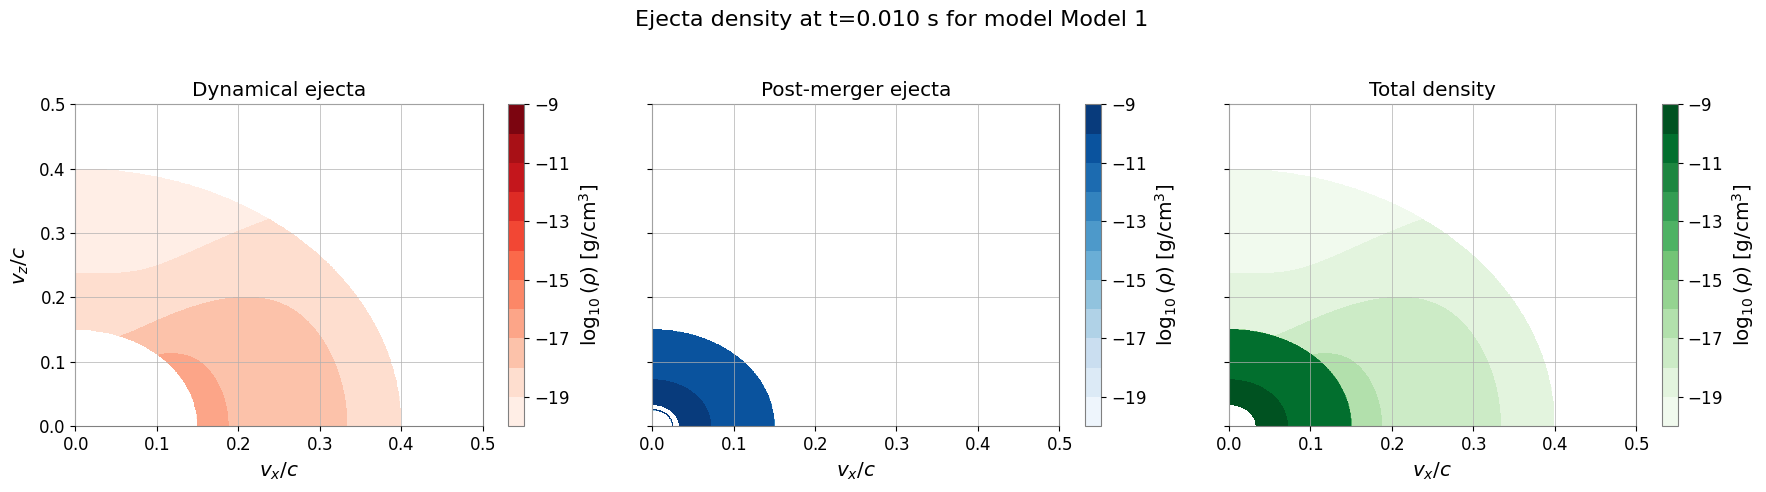

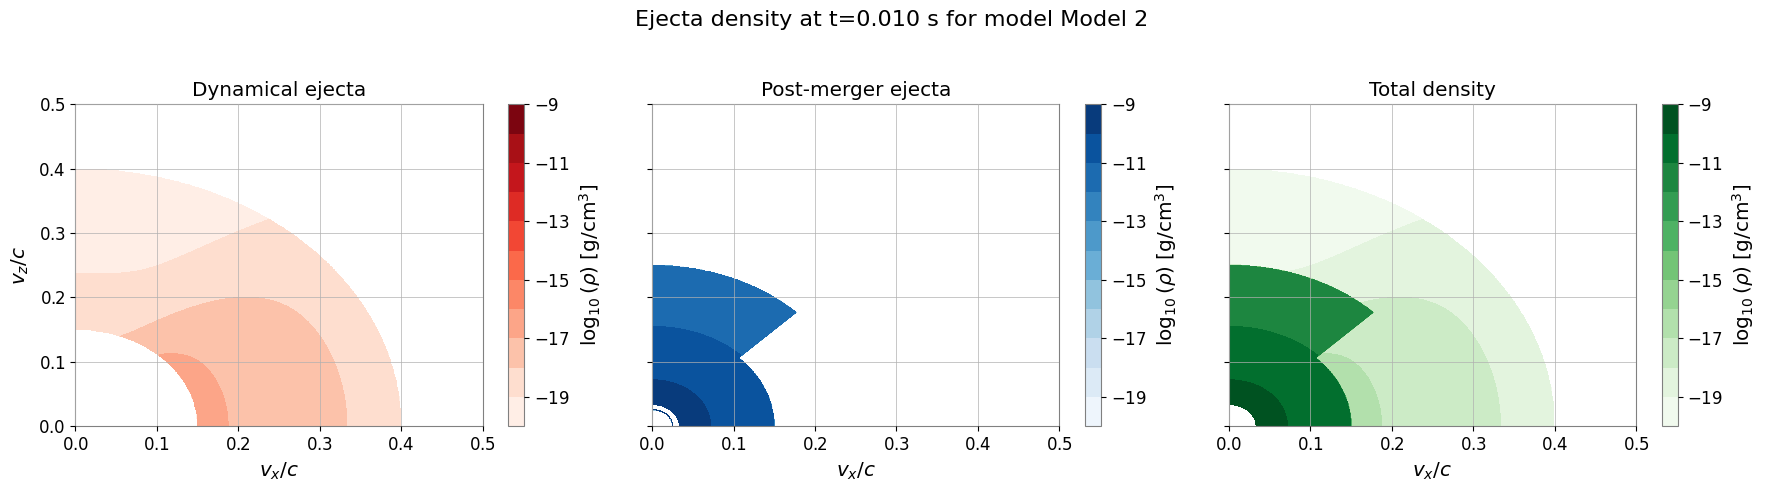

In [4]:
# Model 1 : 
plot_ejecta_density_grid(rho_profile_model1, "Model 1", t=0.01, v_pm_min=0.025, v_pm_max=0.15, v_d_min=0.15, v_max=0.9, n=1000)
# Model 2 avec v_pm_max > v_d_min
plot_ejecta_density_grid(rho_profile_model2, "Model 2", t=0.01, v_pm_min=0.025, v_pm_max=0.25, v_d_min=0.15, v_max=0.9, n=1000) 

Test gif pour voir l'évolution temporelle de la densité d'ejecta pour les 2 modèles

In [ ]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import PillowWriter
# Paramètres du modèle
model = rho_profile_model1  
model_name = "Model 1"
t_values = np.logspace(-2, np.log10(0.5), 30)  # de 0.01s à 0.5s 
v_pm_min = 0.025
v_pm_max = 0.1
v_d_min = 0.15
v_max = 0.9
n = 200
f_d_pol = 0.025

vx_grid = np.linspace(0, v_max, n)
vz_grid = np.linspace(0, v_max, n)
VX, VZ = np.meshgrid(vx_grid, vz_grid)
THETA = np.arctan2(VX, VZ)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
titles = ["Dynamical ejecta", "Post-merger ejecta", "Total density"]
cmaps = ['Reds', 'Blues', 'Greens']
ims = []

levels = np.linspace(-20, -9, 12)

def compute_densities(t):
    rho_dyn = np.zeros_like(VX)
    rho_pm = np.zeros_like(VX)
    rho_tot = np.zeros_like(VX)
    for i in range(n):
        for j in range(n):
            v_tot = np.sqrt(VX[i, j]**2 + VZ[i, j]**2)
            r = v_tot * c * t
            theta_val = THETA[i, j]
            dyn, pm, tot = model(r, t, theta_val, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol)
            rho_dyn[i, j] = dyn
            rho_pm[i, j] = pm
            rho_tot[i, j] = tot
    return rho_dyn, rho_pm, rho_tot

# Initialisation
def init():
    for ax in axes:
        ax.clear()
    for ax, title in zip(axes, titles):
        ax.set_xlabel(r'$v_x/c$')
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 0.5)
        ax.set_title(title)
    axes[0].set_ylabel(r'$v_z/c$')
    return axes

# Animation update
def animate(frame):
    t = t_values[frame]
    rho_dyn, rho_pm, rho_tot = compute_densities(t)
    datas = [rho_dyn, rho_pm, rho_tot]
    for ax, data, cmap in zip(axes, datas, cmaps):
        ax.clear()
        im = ax.contourf(VX, VZ, np.log10(data + 1e-30), levels=levels, cmap=cmap) #Ajout de 1e-30 pour ne pas diviser par 0
        ax.set_xlabel(r'$v_x/c$')
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 0.5)
    axes[0].set_ylabel(r'$v_z/c$')
    axes[0].set_title("Dynamical ejecta")
    axes[1].set_title("Post-merger ejecta")
    axes[2].set_title("Total density")
    fig.suptitle(f"Ejecta density at t={t:.3f} s for {model_name}", fontsize=16)
    return axes

ani = animation.FuncAnimation(fig, animate, frames=len(t_values), init_func=init, blit=False, interval=250)
outdir = 'ejecta_density_plot'
writer = PillowWriter(fps=8)
ani.save(f'{outdir}/ejecta_density_{model_name.replace(" ", "_")}.gif', writer=writer, dpi=200)
plt.close(fig)
HTML(ani.to_jshtml())

In [7]:
from IPython.display import HTML
from matplotlib import animation
from matplotlib.animation import PillowWriter
# Paramètres du modèle
model = rho_profile_model2  
model_name = "Model 2"
t_values = np.logspace(-2, np.log10(0.5), 30)  # de 0.01s à 0.5s 
v_pm_min = 0.025
v_pm_max = 0.25
v_d_min = 0.15
v_max = 0.9
n = 200
f_d_pol = 0.025

vx_grid = np.linspace(0, v_max, n)
vz_grid = np.linspace(0, v_max, n)
VX, VZ = np.meshgrid(vx_grid, vz_grid)
THETA = np.arctan2(VX, VZ)

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)
titles = ["Dynamical ejecta", "Post-merger ejecta", "Total density"]
cmaps = ['Reds', 'Blues', 'Greens']
ims = []

levels = np.linspace(-20, -9, 12) # densité entre 10-20 et 10-9

def compute_densities(t):
    rho_dyn = np.zeros_like(VX)
    rho_pm = np.zeros_like(VX)
    rho_tot = np.zeros_like(VX)
    for i in range(n):
        for j in range(n):
            v_tot = np.sqrt(VX[i, j]**2 + VZ[i, j]**2)
            r = v_tot * c * t
            theta_val = THETA[i, j]
            dyn, pm, tot = model(r, t, theta_val, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol)
            rho_dyn[i, j] = dyn
            rho_pm[i, j] = pm
            rho_tot[i, j] = tot
    return rho_dyn, rho_pm, rho_tot

# Initialisation
def init():
    for ax in axes:
        ax.clear()
    for ax, title in zip(axes, titles):
        ax.set_xlabel(r'$v_x/c$')
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 0.5)
        ax.set_title(title)
    axes[0].set_ylabel(r'$v_z/c$')
    return axes

# Animation update
def animate(frame):
    t = t_values[frame]
    rho_dyn, rho_pm, rho_tot = compute_densities(t)
    datas = [rho_dyn, rho_pm, rho_tot]
    for ax, data, cmap in zip(axes, datas, cmaps):
        ax.clear()
        im = ax.contourf(VX, VZ, np.log10(data + 1e-30), levels=levels, cmap=cmap)
        ax.set_xlabel(r'$v_x/c$')
        ax.set_xlim(0, 0.5)
        ax.set_ylim(0, 0.5)
    axes[0].set_ylabel(r'$v_z/c$')
    axes[0].set_title("Dynamical ejecta")
    axes[1].set_title("Post-merger ejecta")
    axes[2].set_title("Total density")
    fig.suptitle(f"Ejecta density at t={t:.3f} s for {model_name}", fontsize=16)
    return axes

ani = animation.FuncAnimation(fig, animate, frames=len(t_values), init_func=init, blit=False, interval=250)
outdir = 'ejecta_density_plot'
writer = PillowWriter(fps=8)
ani.save(f'{outdir}/ejecta_density_{model_name.replace(" ", "_")}.gif', writer=writer, dpi=200)
plt.close(fig)
HTML(ani.to_jshtml())

Test plot 3D de la densité d'éjecta (check si ejecta dynamique est bien equatorial)

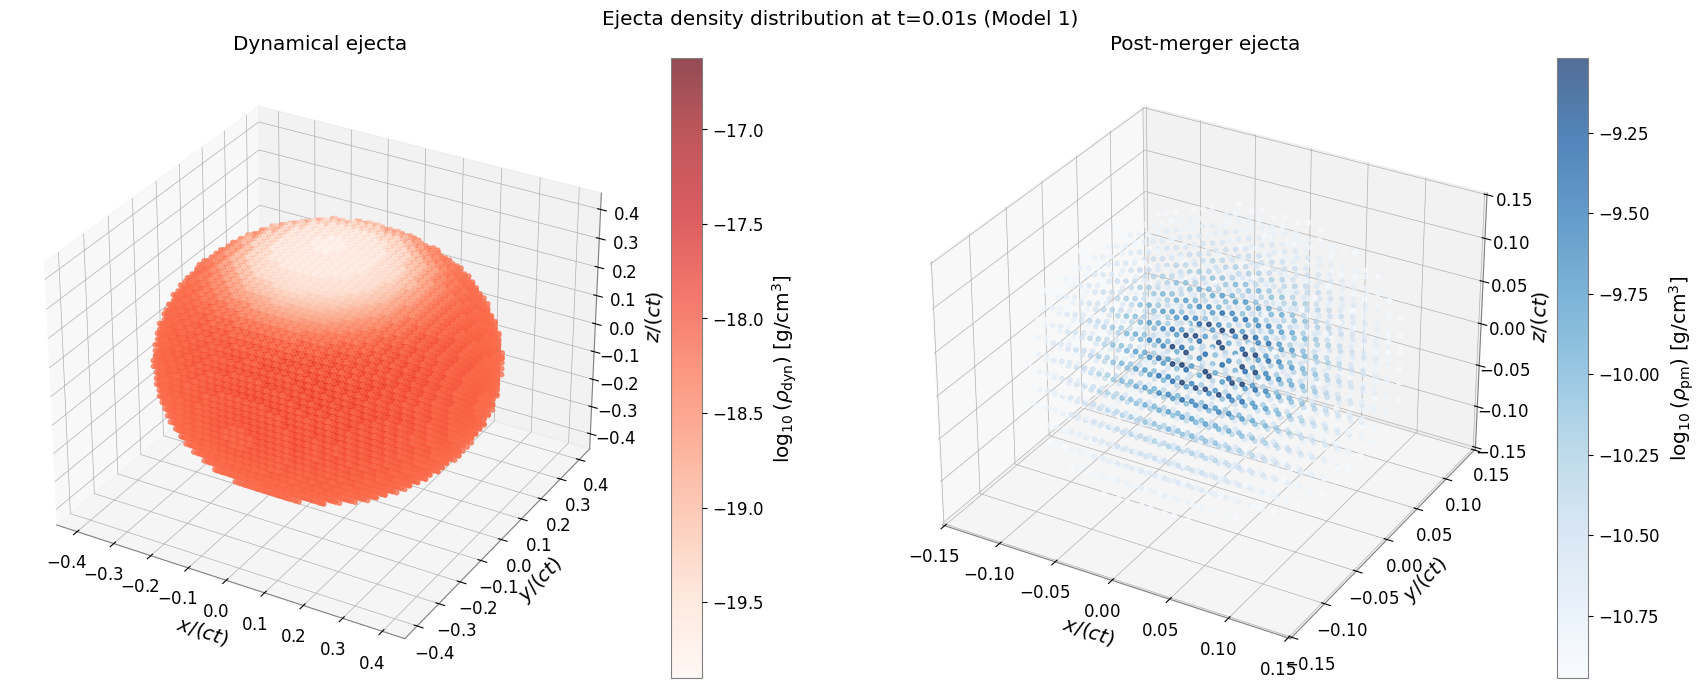

In [8]:
from mpl_toolkits.mplot3d import Axes3D  
t = 0.01
v_pm_min = 0.025
v_pm_max = 0.15
v_d_min = 0.15
v_max = 0.5
n = 50
f_d_pol = 0.025

# Grille en x, y, z centrée en 0
L = v_max * c * t
x = np.linspace(-L, L, n)
y = np.linspace(-L, L, n)
z = np.linspace(-L, L, n)
X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Conversion en coordonnées sphériques
R = np.sqrt(X**2 + Y**2 + Z**2) # R = rayon
THETA = np.arccos(np.clip(Z / (R + 1e-30), -1, 1))  # éviter division par 0 

# Calcul des densités
rho_dyn = np.zeros_like(R)
rho_pm = np.zeros_like(R)
for i in range(n):
    for j in range(n):
        for k in range(n):
            r = R[i, j, k]
            theta = THETA[i, j, k]
            dyn, pm, _ = rho_profile_model1(r, t, theta, v_pm_min, v_pm_max, v_d_min, v_max, f_d_pol)
            rho_dyn[i, j, k] = dyn
            rho_pm[i, j, k] = pm

# Masques pour ne garder que les points significatifs
mask_dyn = rho_dyn > 1e-22
mask_pm = rho_pm > 1e-22

# Plot 3D scatter côte à côte
fig = plt.figure(figsize=(18, 7))

# Dynamical ejecta
ax1 = fig.add_subplot(121, projection='3d')
sc1 = ax1.scatter(
    X[mask_dyn]/(c*t), Y[mask_dyn]/(c*t), Z[mask_dyn]/(c*t),
    c=np.log10(rho_dyn[mask_dyn]), cmap='Reds', s=10, alpha=0.7
)
ax1.set_title("Dynamical ejecta")
ax1.set_xlabel(r'$x/(ct)$')
ax1.set_ylabel(r'$y/(ct)$')
ax1.set_zlabel(r'$z/(ct)$')
fig.colorbar(sc1, ax=ax1, label=r'$\log_{10}(\rho_\mathrm{dyn})$ [g/cm$^3$]')

# Post-merger ejecta
ax2 = fig.add_subplot(122, projection='3d')
sc2 = ax2.scatter(
    X[mask_pm]/(c*t), Y[mask_pm]/(c*t), Z[mask_pm]/(c*t),
    c=np.log10(rho_pm[mask_pm]), cmap='Blues', s=10, alpha=0.7
)
ax2.set_title("Post-merger ejecta")
ax2.set_xlabel(r'$x/(ct)$')
ax2.set_ylabel(r'$y/(ct)$')
ax2.set_zlabel(r'$z/(ct)$')
fig.colorbar(sc2, ax=ax2, label=r'$\log_{10}(\rho_\mathrm{pm})$ [g/cm$^3$]')
plt.suptitle(f"Ejecta density distribution at t={t}s (Model 1)")
plt.tight_layout()
plt.show()